<a href="https://colab.research.google.com/github/Zhuoyue-Huang/urop_2022_ml/blob/main/FE_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [264]:
"""Verify the gradient derivation of linear masked autoencoder."""
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import numpy as np
import pandas as pd 
import scipy.stats as stats
from torch.distributions.exponential import Exponential

In [265]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [266]:
# set default to be float64
torch.set_default_dtype(torch.float64)

### Model initialisation

In [267]:
## Masked lienar auto-encoder model
# Define different types of masks
def mask_basic(prob, sample_num, x_dim):
    return torch.zeros(sample_num, x_dim).bernoulli_(prob)

def mask_probs(prob_list: torch.Tensor, sample_num, x_dim):
    return torch.zeros(sample_num, x_dim).bernoulli_(prob_list)

def mask_patches_block(prob, patch_size: torch.Tensor, sample_num, sample_dim: torch.Tensor):
    x_dim = sample_dim[0]*sample_dim[1]
    div_check = sample_dim % patch_size == torch.zeros(2)
    if torch.all(div_check):
        pix_num = torch.div(sample_dim, patch_size, rounding_mode='floor')
        mat_patches = torch.zeros(sample_num, *pix_num).bernoulli_(prob)
        mat_patches = torch.repeat_interleave(mat_patches, patch_size[1], dim=2)
        return mat_patches.repeat_interleave(patch_size[0], dim=1).view(sample_num, x_dim)
    else:
        raise NotImplementedError(f"Both height ({sample_dim[0]}) and width ({sample_dim[1]}) should be divisible by patch_size ({patch_size}).")

def mask_patches_plain(prob, patch_size, sample_num, x_dim):
    if not x_dim % patch_size:
        pix_num = x_dim // patch_size
        mat_patches = torch.zeros(sample_num, pix_num).bernoulli_(prob)
        return mat_patches.repeat_interleave(patch_size, dim=1)
    else:
        raise NotImplementedError

In [268]:
def feature_extraction(data_dict, f_dim, criterion, model_type, prob=None, prob_list=None, patch_size=None, device='cuda'):
    X_train, _, X_val, _, _, _ = data_dict.values()
    train_num, x_dim = X_train.shape
    val_num = X_val.shape[0]
    if model_type == 'LAE':
        Sigma = X_train.T @ X_train
        U, _, _ = torch.linalg.svd(Sigma)
        U = U[:, :f_dim]
        W1 = U.T
        W2 = U
        loss = criterion(X_val@W1.T@W2.T, X_val)
    elif model_type == 'MLAE_basic':
        X = mask_basic(prob, train_num, x_dim).to(device) * X_train
        Y = X_train
        try:
            torch.inverse(X.T@X)
        except torch._C._LinAlgError:
            # Sigma_XX = X.T@X
            # U_XX, S_XX, Vh_XX = torch.linalg.svd(Sigma_XX)
            # print(S_XX)
            # inv = Vh_XX.T*torch.inverse(torch.diag(S_XX+1e-4))*U_XX.T
        
            perturbation = torch.diag(torch.ones(x_dim)*1e-25).to(device)
            inv = torch.inverse(X.T@X+perturbation)
        else:
            inv = torch.inverse(X.T@X)
        if prob == 1:
            Sigma = X.T@X
            U, _, _ = torch.linalg.svd(Sigma)
            U = U[:, :f_dim]
            W1 = U.T
            W2 = U
            loss = criterion(X_val@W1.T@W2.T, X_val)
        else:
            Sigma = Y.T@X @ inv @ X.T@Y
            U, _, _ = torch.linalg.svd(Sigma)
            U = U[:, :f_dim]
            W1 = U.T @ Y.T@X @ inv
            W2 = U
            loss = criterion((mask_basic(prob, val_num, x_dim).to(device)*X_val)@W1.T@W2.T, X_val)
    elif model_type == 'MLAE_probs':
        X = mask_probs(prob_list, train_num, x_dim).to(device) * X_train
        Y = X_train
        perturbation = torch.diag(torch.ones(x_dim)*1e-16).to(device)
        inv = torch.inverse(X.T@X + perturbation)
        Sigma = Y.T@X @ inv @ X.T@Y
        U, _, _ = torch.linalg.svd(Sigma)
        U = U[:, :f_dim]
        W1 = U.T @ Y.T@X @ inv
        W2 = U
        loss = criterion((mask_probs(prob_list, val_num, x_dim).to(device)*X_val)@W1.T@W2.T, X_val)
    elif model_type == 'MLAE_patches':
        X = mask_patches_plain(prob, patch_size, train_num, x_dim).to(device) * X_train
        Y = X_train
        try:
            torch.inverse(X.T@X)
        except torch._C._LinAlgError:
            # Sigma_XX = X.T@X
            # U_XX, S_XX, Vh_XX = torch.linalg.svd(Sigma_XX)
            # print(S_XX)
            # inv = Vh_XX.T*torch.inverse(torch.diag(S_XX+1e-4))*U_XX.T
        
            perturbation = torch.diag(torch.ones(x_dim)*1e-25).to(device)
            inv = torch.inverse(X.T@X+perturbation)
        else:
            inv = torch.inverse(X.T@X)
        if prob == 1:
            Sigma = X.T@X
            U, _, _ = torch.linalg.svd(Sigma)
            U = U[:, :f_dim]
            W1 = U.T
            W2 = U
            loss = criterion(X_val@W1.T@W2.T, X_val)
        else:
            Sigma = Y.T@X @ inv @ X.T@Y
            U, _, _ = torch.linalg.svd(Sigma)
            U = U[:, :f_dim]
            W1 = U.T @ Y.T@X @ inv
            W2 = U
            loss = criterion((mask_patches_plain(prob, patch_size, val_num, x_dim).to(device)*X_val)@W1.T@W2.T, X_val)
    return (W1, loss.cpu().item())

In [269]:
# representation learning
def repr_learning(data_dict, W1, criterion, device='cuda'):
    X_train, y_train, _, _, X_test, y_test = data_dict.values()

    f_train = X_train @ W1.T
    f_test = X_test @ W1.T
    f_dim = f_train.shape[1]
    y_dim = y_train.shape[1]

    theta = (torch.inverse(f_train.T @ f_train) @ f_train.T @ y_train).T
    loss = criterion(y_test, f_test @ theta.T)
    return loss.item()

### Dataset

In [270]:
train_num, val_num, test_num = (4000, 500, 2000) # larger number of dataset
sample_num_split = (train_num, train_num + val_num)
total = train_num+val_num+test_num

# need to consider f_dim <, =, > z_dim
z_dim = 10 # dimension of z
H = 4
W = 4
sample_dim = torch.tensor([H, W])
x_dim = H * W
f_dim = 14
y_dim = z_dim // 2

prob_search = torch.range(0, 1, 0.05)
prob_list_search = torch.rand(x_dim, generator=torch.random.manual_seed(1911))*0.2\
                   + torch.repeat_interleave(torch.range(0, 0.8, 0.05).unsqueeze(1), x_dim, dim=1)
patch_size_plain_search = torch.tensor([2, 4, 8])
patch_size_block_search = []
for i in [2, 4, 8]:
    for j in [2, 4, 8]:
        patch_size_block_search.append([i, j])
patch_size_search = torch.tensor(patch_size_block_search)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  app.launch_new_instance()


In [271]:
#mean = torch.linspace(0, 5, z_dim).repeat(total, 1)
#std = torch.linspace(3, 8, z_dim).repeat(total, 1)
#m = Exponential(1)
#z = m.rsample((total,z_dim))
#z = torch.normal(mean=mean, std=std, generator=torch.random.manual_seed(1911))
z = torch.normal(mean=0, std=1, size=(total,z_dim), generator=torch.random.manual_seed(1911)) # here distribution is high dimensional guassian
z = z.to(device)

In [272]:
U = torch.rand(x_dim, z_dim, generator=torch.random.manual_seed(1911))
U = U.to(device)
V = torch.rand(y_dim, z_dim, generator=torch.random.manual_seed(1911))
V = V.to(device)

x = z @ U.T
y = z @ V.T
X_train, X_val, X_test = torch.tensor_split(x, sample_num_split)
y_train, y_val, y_test = torch.tensor_split(y, sample_num_split)
data_dict = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val, 'X_test': X_test, 'y_test': y_test}
#fe_loss_dict = {'LAE': [], 'MLAE_basic': [], 'MLAE_probs': [], 'MLAE_patches': []}

In [273]:
epochs_grid = 50
criterion = nn.MSELoss()

### Get features from autoencoder

##### Linear autoencoder

In [274]:
W1, fe_loss = feature_extraction(data_dict, f_dim, criterion, model_type='LAE')
print('feature extraction loss:', fe_loss)
rl_loss = repr_learning(data_dict, W1, criterion)
print('representation learning loss:', rl_loss)

feature extraction loss: 1.6356640622827573e-29
representation learning loss: 5.0524731780626245e-27


In [275]:
#print('mean:', statistics.mean(fe_loss_dict['LAE']), ', sd:', statistics.stdev(fe_loss_dict['LAE']))

##### Masked linear autoencoder (basic)

In [276]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8}

for prob in tqdm(prob_search):
    W1, loss = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_basic', prob=prob)
    search_score.append(loss)
    if loss < search_record['best_score']:
        search_record['best_score'] = loss
        search_record['params'] = prob

100%|██████████| 21/21 [00:00<00:00, 197.94it/s]


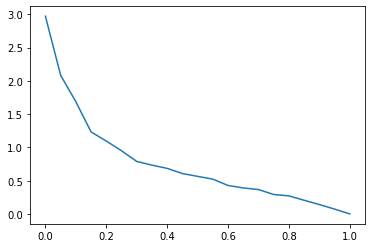

In [277]:
# search check
plt.plot(prob_search, search_score)

In [278]:
prob = search_record['params']
print('prob:', prob.item(), '\nloss:', loss)

prob: 1.0 
loss: 1.6356640622827573e-29


In [279]:
W1, fe_loss = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_basic', prob=prob)
print('feature extraction loss:', fe_loss)
rl_loss = repr_learning(data_dict, W1, criterion)
print('representation learning loss:', rl_loss)

feature extraction loss: 1.6356640622827573e-29
representation learning loss: 5.0524731780626245e-27


In [280]:
#print('mean:', statistics.mean(fe_loss_dict['MLAE_basic']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_basic']))

##### Masked linear autoencoder (probs)

In [281]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8}

for prob_list in tqdm(prob_list_search):
    W1, loss = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_probs', prob_list=prob_list)
    search_score.append(loss)
    if loss < search_record['best_score']:
        search_record['best_score'] = loss
        search_record['params'] = prob_list

100%|██████████| 17/17 [00:00<00:00, 205.74it/s]


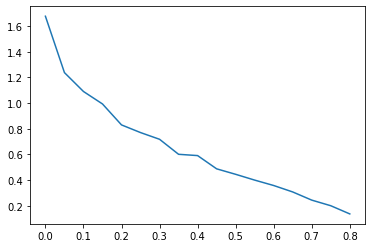

In [282]:
# search check
plt.plot(list(prob_search)[:17], search_score)

In [283]:
prob_list = search_record['params']
print('prob:', prob_list, '\nloss:', loss)

prob: tensor([0.9429, 0.9029, 0.8814, 0.8644, 0.8603, 0.8468, 0.9667, 0.9169, 0.8851,
        0.8440, 0.8102, 0.8919, 0.9371, 0.8715, 0.8871, 0.9910]) 
loss: 0.13671838308445428


In [284]:
W1, fe_loss = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_probs', prob_list=prob_list)
print('feature extraction loss:', fe_loss)
rl_loss = repr_learning(data_dict, W1, criterion)
print('representation learning loss:', rl_loss)

feature extraction loss: 0.12353492300165209
representation learning loss: 0.11511140094620241


In [285]:
#print('mean:', statistics.mean(fe_loss_dict['MLAE_probs']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_probs']))

##### Masked linear autoencoder (patches)

In [286]:
# grid search
search_score = []
search_record = {'params': -1, 'best_score': 1e8}

for prob in tqdm(prob_search):
    for patch_size in patch_size_plain_search:
        W1, loss = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_patches', prob=prob, patch_size=patch_size)

        search_score.append(loss)
        if loss < search_record['best_score']:
            search_record['best_score'] = loss
            search_record['params'] = (prob, patch_size)

100%|██████████| 21/21 [00:00<00:00, 78.70it/s]


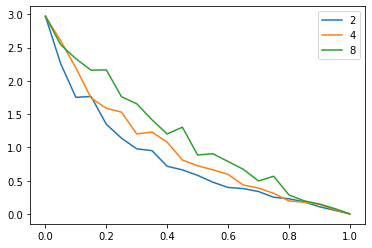

In [289]:
# search check
for i in range(3):
    plt.plot(prob_search, search_score[i::3])
plt.legend([str(patch_size.item()) for patch_size in patch_size_plain_search])

In [290]:
prob, patch_size = search_record['params']
print('prob:', prob, ',\npatch_size:', patch_size.item(), ',\nloss:', loss)

prob: tensor(1.) ,
patch_size: 2 ,
loss: 1.6356640622827573e-29


In [291]:
# feature extraction
W1, fe_loss = feature_extraction(data_dict, f_dim, criterion, model_type='MLAE_patches', prob=prob, patch_size=patch_size)
print('feature extraction loss:', fe_loss)
rl_loss = repr_learning(data_dict, W1, criterion)
print('representation learning loss:', rl_loss)

feature extraction loss: 1.6356640622827573e-29
representation learning loss: 5.0524731780626245e-27


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [292]:
#print('mean:', statistics.mean(fe_loss_dict['MLAE_patches']), ', sd:', statistics.stdev(fe_loss_dict['MLAE_patches']))

### Evaluation

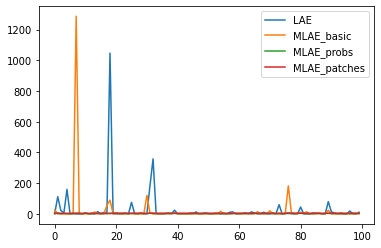

In [ ]:
plt.plot(fe_loss_dict['LAE'])
plt.plot(fe_loss_dict['MLAE_basic'])
plt.plot(fe_loss_dict['MLAE_probs'])
plt.plot(fe_loss_dict['MLAE_patches'])
plt.legend(['LAE', 'MLAE_basic', 'MLAE_probs', 'MLAE_patches'])

In [ ]:
fe_stats_dict = {'LAE': {'mean': statistics.mean(fe_loss_dict['LAE']), 'sd': statistics.stdev(fe_loss_dict['LAE'])},
                 'MLAE_basic': {'mean': statistics.mean(fe_loss_dict['MLAE_basic']), 'sd': statistics.stdev(fe_loss_dict['MLAE_basic'])},
                 'MLAE_probs': {'mean': statistics.mean(fe_loss_dict['MLAE_probs']), 'sd': statistics.stdev(fe_loss_dict['MLAE_probs'])},
                 'MLAE_patches': {'mean': statistics.mean(fe_loss_dict['MLAE_patches']), 'sd': statistics.stdev(fe_loss_dict['MLAE_patches'])}}
print(fe_stats_dict)

{'LAE': {'mean': 24.28822666196855, 'sd': 112.77483075262933}, 'MLAE_basic': {'mean': 19.764446280136564, 'sd': 130.27021268330387}, 'MLAE_probs': {'mean': 3.5287499164980014, 'sd': 1.076605118355581}, 'MLAE_patches': {'mean': 3.500800313630066, 'sd': 0.827311253735518}}


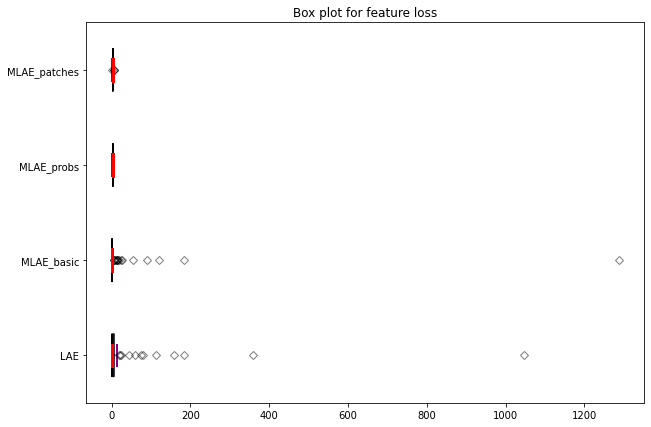

In [ ]:
data = fe_loss_dict.values()
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0)
 
colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_yticklabels(fe_loss_dict.keys())
#ax.set_yticklabels(patch_dict.keys())
 
# Adding title
plt.title("Box plot for feature loss")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()